# test DL models

## so much import

In [15]:
import os
import sys
import pandas as pd
import numpy as np
import re
import PATH
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader,Dataset,random_split
from tqdm import tqdm

from matplotlib import pyplot as plt
import scipy.stats as stats
import seaborn as sns

from models.popen import Auto_popen
from models import ScheduleOptimizer
from models.ScheduleOptimizer import ScheduledOptim 
from models.log_and_save import Log_parser,plot_a_exp_set
from models import reader
from models import DL_models
from models import CNN_models
import utils
from utils import Seq_one_hot,read_UTR_csv,read_label,resume,setup_logs

In [3]:
from importlib import reload
from models import popen

In [4]:
import logging

# regression model

In [5]:
import PATH
from models import Baseline_models
from models import log_and_save as LAS
from models.popen import Auto_popen
from importlib import reloadb

from models import popen
reload(reader)
reload(popen)

<module 'models.popen' from '/home/wergillius/Project/UTR_VAE/models/popen.py'>

<font size=4 color='skyblue'>**Popen**</font>


<font size=4 color='skyblue'>**Load DataLoader**</font>

In [11]:
logger = setup_logs("test_log.log")

In [7]:
def regression_result(config_path,out_posi=None):
    

    """read config and popen"""
    assert os.path.exists(config_path) , "ini-file path error : file not found"
    unmod_mse_popen = popen.Auto_popen(config_path)


    """read model"""
    mse_model = unmod_mse_popen.Model_Class(*unmod_mse_popen.model_args)
    check_point = torch.load(unmod_mse_popen.vae_pth_path)
    mse_model.load_state_dict(check_point['state_dict'])
    mse_model=mse_model.cuda()
    
    print(" \t \tmodel loaded successfully ! ! \n")


    """read data"""
    dataset = reader.MTL_enc_dataset(unmod_mse_popen.csv_path,columns=['indexx','scaled_rl'])
    train_loader,val_loader = reader.get_splited_dataloader(dataset,
                                                ratio=[0.8,0.2],
                                                batch_size=168,
                                                num_workers=8)
    
#     print(" \t \t data read ! ! \n")
    """list"""
    Y_true = []
    index_ls = []
    Y_pred = []
    utr = []
    
    """forward"""
    with torch.no_grad():
        for data in tqdm(val_loader):
            X,Y = data
            X = X.float().cuda()
            index_ls.append(Y[:,0].numpy())
            Y_true.append(Y[:,1].numpy())

            out = mse_model(X)
            if type(out_posi) == int:
                out = out[out_posi]
            Y_pred.append(out.cpu().numpy())
            
            torch.cuda.empty_cache()

    Y_pred = np.concatenate(Y_pred).squeeze()
    Y_true = np.concatenate(Y_true).squeeze()
    index_ls = np.concatenate(index_ls).squeeze()

    unmod_df = pd.read_csv('/data/users/wergillius/UTR_VAE/multi_task/scaled_unmod.csv')
    
    """get sequence by index"""
    val_df = unmod_df.loc[index_ls,['utr']]

    detect_atg = lambda x: 'ATG' in x

    val_df.loc[:,'Y_true'] = Y_true
    val_df.loc[:,'Y_pred'] = Y_pred
    val_df.loc[:,'uATG'] = val_df.utr.apply(detect_atg)
    
    return val_df

In [180]:
hinge = regression_result("/home/wergillius/Project/UTR_VAE/log/Baseline_MTL/unmod_df/unmod_hinge.ini")

100%|██████████| 334/334 [00:43<00:00,  7.72it/s]


In [221]:
unmode_hinge_slr_df = regression_result("/home/wergillius/Project/UTR_VAE/log/Baseline_MTL/unmod_df/unmod_hinge_slr.ini")

 	 	model loaded successfully ! ! 



  0%|          | 0/334 [00:00<?, ?it/s]

 	 	 data read ! ! 



100%|██████████| 334/334 [00:40<00:00,  8.34it/s]


In [222]:
unmod_mse_slr_df = regression_result("/home/wergillius/Project/UTR_VAE/log/Baseline_MTL/unmod_df/unmod_mse_slr.ini")

 	 	model loaded successfully ! ! 



  0%|          | 0/334 [00:00<?, ?it/s]

 	 	 data read ! ! 



100%|██████████| 334/334 [00:39<00:00,  8.50it/s]


## plot regression

In [15]:
sns.set_style("white")
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black'})
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['axes.labelweight'] = 'normal'
plt.rcParams['axes.labelpad'] = 5
plt.rcParams['axes.linewidth']= 2
plt.rcParams['xtick.labelsize']= 14
plt.rcParams['ytick.labelsize']= 14
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.edgecolor'] = 'black'

# fig = plt.figure(figsize=(9,9))
# ax = fig.gca()
# dots = ax.scatter(Y_true,Y_pred,s=20,alpha=0.2,color=(0.3, 0.45, 0.69))
# ax1 = 

def sns_kde_scatter(val_df,**kwargs):
    atg = val_df[val_df.uATG == True]
    n_atg = val_df[val_df.uATG == False]
    c1 = (0.3, 0.45, 0.69)
    c2 = 'r'
    g = sns.JointGrid(x='Y_true', y="Y_pred", data=atg, space=0, ratio=6, height=7)
    g.plot_joint(plt.scatter,s=15, color=c1, linewidth=0.2, alpha=0.1, edgecolor='black',**kwargs)
    f = g.fig
    ax = f.gca()
    # ax.set_yticks(np.arange(0,9.01, 1));
    # ax.set_yticklabels(range(10),size=20);
    # ax.set_xticks(np.arange(1,10.01, 1));
    # ax.set_xticklabels(range(1,11),size=20);
    ax.set_ylim(-4,2.5)
    ax.set_xlim(-4,2.5)
    g.plot_marginals(sns.kdeplot,shade=c1, **{'linewidth':2, 'color':c1})
    g.set_axis_labels('Observed MRL', 'Predicted MRL', **{'size':22});



    g.x = n_atg['Y_true'].values
    g.y = n_atg['Y_pred'].values
    g.plot_joint(plt.scatter, s=15, linewidth=0.2, alpha=0.2, color=c2, edgecolor='black')
    g.plot_marginals(sns.kdeplot, shade=c2, **{'linewidth':2, 'color':c2})
    f = g.fig
    
    return f,g,ax

## plot different Loss function

Text(-4.5, 3.7, 'unmod dataset : hinge loss small learning rate')

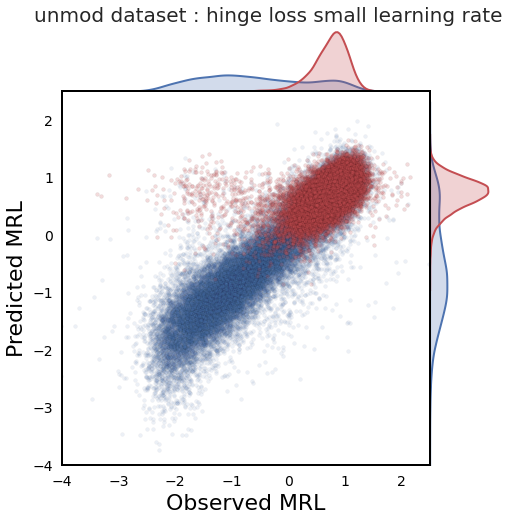

In [257]:
hinge_slr_f = sns_kde_scatter(unmode_hinge_slr_df)
hinge_slr_f[2].text(x=-4.5,y=3.7,s="unmod dataset : hinge loss small learning rate",fontsize=20)

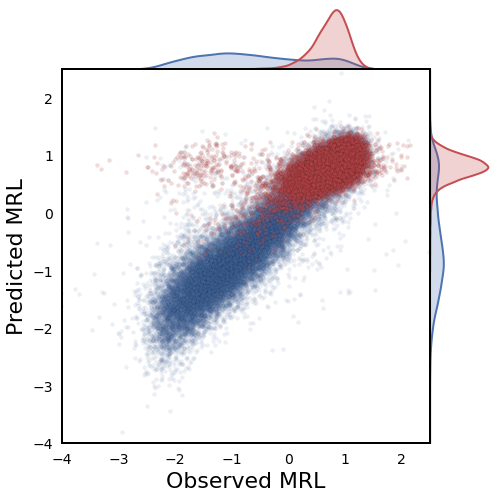

In [218]:
sns_kde_scatter(val_df)

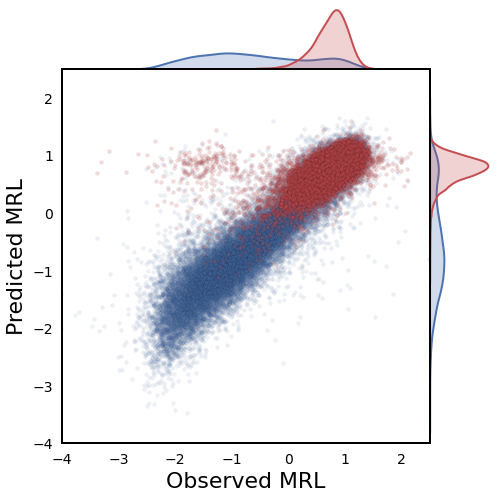

In [219]:
sns_kde_scatter(hinge)

## MODEL : TO_SEQ_TE reg version , setting : weight finder

In [9]:
config_path = "/home/wergillius/Project/UTR_VAE/log/TO_SEQ_TE_MTL/reg_version_weight_finder/w_05_05.ini"

In [11]:
w_5_5 = regression_result(config_path,out_posi=2)

 	 	model loaded successfully ! ! 



100%|██████████| 334/334 [01:01<00:00,  5.41it/s]


(<Figure size 504x504 with 3 Axes>,
 <AxesSubplot:xlabel='Observed MRL', ylabel='Predicted MRL'>)

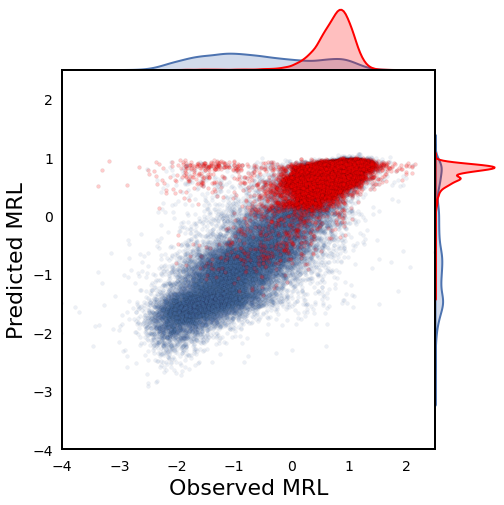

In [14]:
sns_kde_scatter(w_5_5)

In [16]:
config_path = "/home/wergillius/Project/UTR_VAE/log/TO_SEQ_TE_MTL/reg_version_weight_finder/w_1_e-1.ini"

In [17]:
w1_e_1 = regression_result(config_path,out_posi=2)

 	 	model loaded successfully ! ! 



100%|██████████| 334/334 [00:53<00:00,  6.27it/s]


(<Figure size 504x504 with 3 Axes>,
 <AxesSubplot:xlabel='Observed MRL', ylabel='Predicted MRL'>)

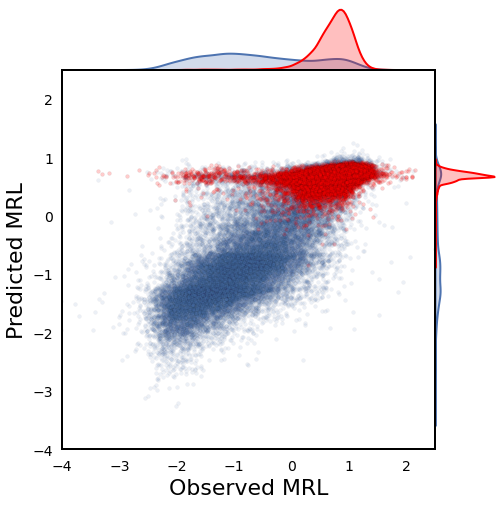

In [18]:
sns_kde_scatter(w1_e_1)

In [19]:
config_path = "/home/wergillius/Project/UTR_VAE/log/TO_SEQ_TE_MTL/reg_version_test/test_run.ini"

In [21]:
test_run = regression_result(config_path,out_posi=2)

 	 	model loaded successfully ! ! 



100%|██████████| 334/334 [00:53<00:00,  6.20it/s]


(<Figure size 504x504 with 3 Axes>,
 <AxesSubplot:xlabel='Observed MRL', ylabel='Predicted MRL'>)

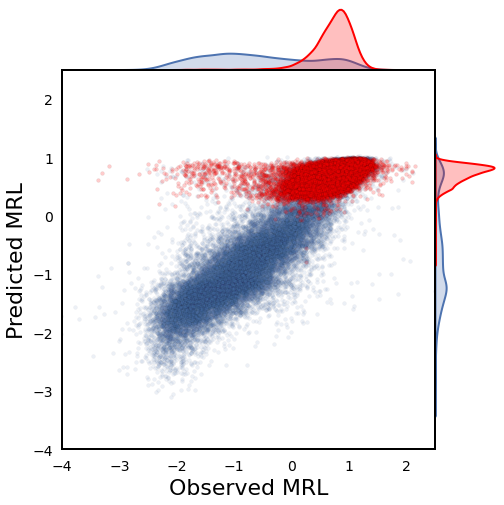

In [22]:
sns_kde_scatter(test_run)

# MODEL : TRANSFORMER_SEQ_RL

In [23]:
config_path = "/home/wergillius/Project/UTR_VAE/log/TRANSFORMER_SEQ_RL_MTL/test_run/test_run.ini"
trans_test = regression_result(config_path,out_posi=2)

 	 	model loaded successfully ! ! 



100%|██████████| 334/334 [00:55<00:00,  6.04it/s]


(<Figure size 504x504 with 3 Axes>,
 <AxesSubplot:xlabel='Observed MRL', ylabel='Predicted MRL'>)

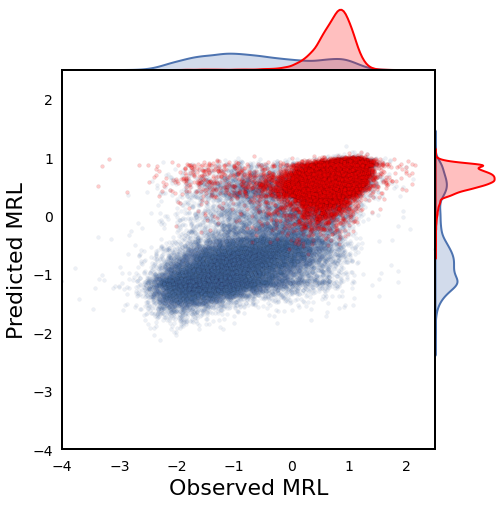

In [24]:
sns_kde_scatter(trans_test)

# Model : RL_regressor